In [57]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [58]:
LABEL_CSV_PATH = '../data/processed/labels.csv'
PREPROCESSED_IMAGE_DIR = '../data/processed/images'
IMAGE_SIZE = 64

In [59]:
# Please ensure the csv file and image directory exist
labels_df = pd.read_csv(LABEL_CSV_PATH)
print(f'Labels DataFrame shape: {labels_df.shape}')
print(f"Labels DataFrame sample:\n{labels_df.head()}")

Labels DataFrame shape: (63565, 23)
Labels DataFrame sample:
         filename     1girl      1boy  blue hair  green hair  red hair  \
0      0_2000.jpg  0.797137  0.105458   0.042771    0.007018  0.023152   
1  10000_2004.jpg  0.924351  0.034629   0.002652    0.000718  0.149207   
2  10001_2004.jpg  0.979556  0.003000   0.002535    0.000122  0.006425   
3  10002_2004.jpg  0.940607  0.018661   0.003866    0.000421  0.059501   
4  10003_2004.jpg  0.883896  0.057419   0.003514    0.001232  0.083294   

   black hair  pink hair  orange hair  purple hair  ...  blue eyes  \
0    0.045303   0.020720     0.009698     0.248016  ...   0.028910   
1    0.004790   0.086271     0.087093     0.007414  ...   0.092170   
2    0.001000   0.188704     0.000562     0.291268  ...   0.007823   
3    0.008206   0.248054     0.001761     0.102811  ...   0.017405   
4    0.015855   0.005546     0.049937     0.002308  ...   0.020730   

   green eyes  red eyes  black eyes  pink eyes  orange eyes  purple eyes 

In [60]:
print(labels_df.describe())

              1girl          1boy     blue hair    green hair      red hair  \
count  63565.000000  63565.000000  63565.000000  63565.000000  63565.000000   
mean       0.934189      0.023985      0.042741      0.011636      0.026805   
std        0.075980      0.048873      0.101088      0.065696      0.071352   
min        0.024894      0.000241      0.000031      0.000006      0.000009   
25%        0.928052      0.005611      0.003496      0.000520      0.002017   
50%        0.956113      0.010583      0.009201      0.001267      0.005508   
75%        0.971371      0.022288      0.027654      0.002962      0.017428   
max        0.996506      0.951302      0.930895      0.964560      0.965422   

         black hair     pink hair   orange hair   purple hair    brown hair  \
count  63565.000000  63565.000000  63565.000000  63565.000000  63565.000000   
mean       0.049985      0.069211      0.006644      0.063637      0.069621   
std        0.090920      0.164539      0.015739    

In [61]:
label_names = labels_df.columns[1:].to_numpy()
filenames = labels_df['filename'].to_numpy()
tags = labels_df.drop(columns=['filename']).to_numpy()
print(f'Label names: {label_names}')
print(f'Filenames: {filenames[:2]}')
print(f'Tags shape: {tags.shape}')
print(f'Tags sample:\n{np.round(tags[:2], 3)}')

Label names: ['1girl' '1boy' 'blue hair' 'green hair' 'red hair' 'black hair'
 'pink hair' 'orange hair' 'purple hair' 'brown hair' 'aqua hair'
 'white hair' 'blue eyes' 'green eyes' 'red eyes' 'black eyes' 'pink eyes'
 'orange eyes' 'purple eyes' 'brown eyes' 'aqua eyes' 'yellow eyes']
Filenames: ['0_2000.jpg' '10000_2004.jpg']
Tags shape: (63565, 22)
Tags sample:
[[0.797 0.105 0.043 0.007 0.023 0.045 0.021 0.01  0.248 0.059 0.001 0.011
  0.029 0.023 0.082 0.02  0.008 0.003 0.038 0.031 0.004 0.022]
 [0.924 0.035 0.003 0.001 0.149 0.005 0.086 0.087 0.007 0.053 0.    0.001
  0.092 0.725 0.001 0.004 0.    0.    0.001 0.001 0.085 0.   ]]


In [62]:
class AnimeFaceDataset(Dataset):
    def __init__(self, root_dir: str, filenames: list, tags: list, transform=None):
        self.root_dir = root_dir
        self.filenames = filenames
        self.tags = tags
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.filenames[idx])
        # Load image using OpenCV
        image = cv2.imdecode(np.fromfile(
            image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
        # Convert from BGR to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert to PyTorch tensor and normalize to [0, 1]
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        label = self.tags[idx]
        return image, label

In [63]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = AnimeFaceDataset(
    root_dir=PREPROCESSED_IMAGE_DIR,
    filenames=filenames,
    tags=tags,
    transform=transform
)

In [64]:
sample_index = 4
sample_image, sample_label = dataset[sample_index]

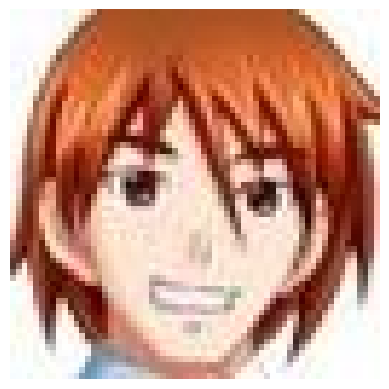

In [65]:
def show_image(image):
    """Utility function to display an image."""
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    image = (image + 1) / 2.0  # Denormalize to [0, 1]
    plt.imshow(image)
    plt.axis('off')
    plt.show()


show_image(sample_image)

In [66]:
print(f'Dataset length: {len(dataset)}')
print(f'First image shape: {sample_image.shape}')
print(f'First label shape: {sample_label.shape}')

for tag_name, tag_value in zip(label_names, sample_label):
    print(f'{tag_name}: {np.round(tag_value, 4)}')

Dataset length: 63565
First image shape: torch.Size([3, 64, 64])
First label shape: (22,)
1girl: 0.8839
1boy: 0.0574
blue hair: 0.0035
green hair: 0.0012
red hair: 0.0833
black hair: 0.0159
pink hair: 0.0055
orange hair: 0.0499
purple hair: 0.0023
brown hair: 0.1415
aqua hair: 0.0001
white hair: 0.0012
blue eyes: 0.0207
green eyes: 0.026
red eyes: 0.0351
black eyes: 0.0538
pink eyes: 0.0024
orange eyes: 0.0048
purple eyes: 0.0066
brown eyes: 0.1419
aqua eyes: 0.0014
yellow eyes: 0.0124


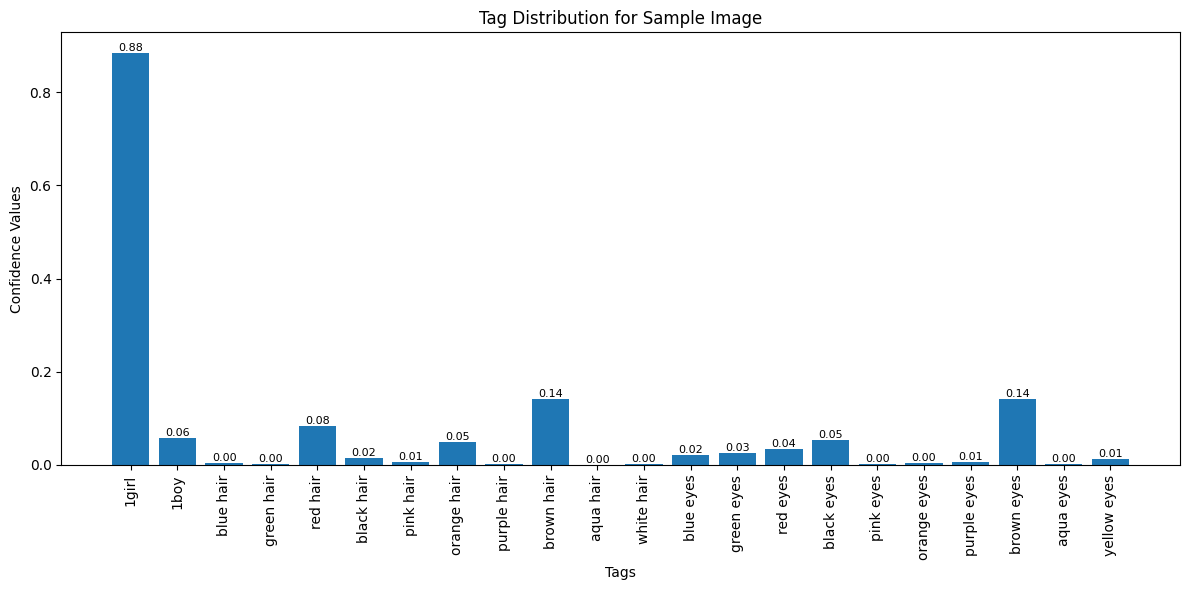

In [67]:
# Create a bar chart to visualize the tag values
plt.figure(figsize=(12, 6))
bars = plt.bar(label_names, sample_label)
plt.xticks(rotation=90)
plt.xlabel('Tags')
plt.ylabel('Confidence Values')
plt.title('Tag Distribution for Sample Image')

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [68]:
# Define category groups
sex_tags = label_names[0:2]
hair_color_tags = label_names[2:12]
eye_color_tags = label_names[12:22]

# Count the number of images with tag values > threshold for each category
threshold = 0.1
tag_counts = (tags > threshold).sum(axis=0)

# Create a DataFrame for better visualization
tag_distribution = pd.DataFrame({
    'Tag': label_names,
    'Count': tag_counts,
    'Category': ['Sex']*2 + ['Hair Color']*10 + ['Eye Color']*10
})

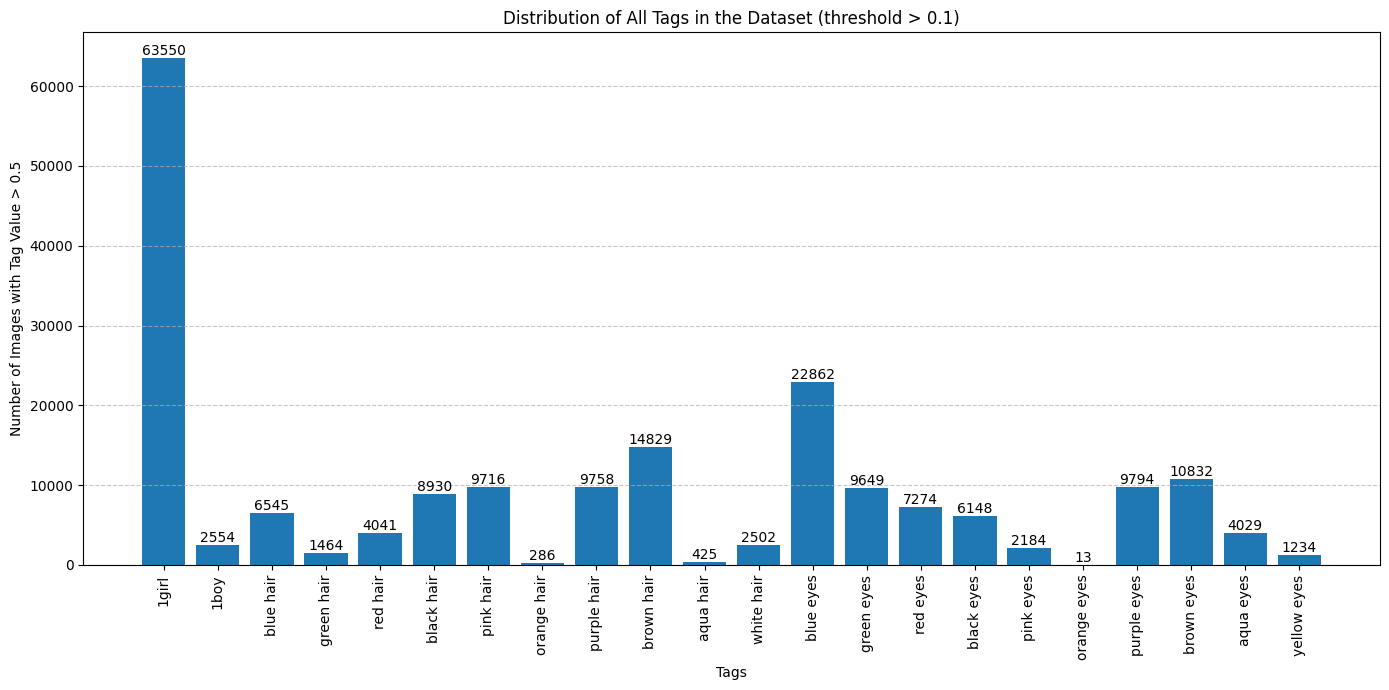

In [69]:
# Calculate percentage of total for each tag
total_images = len(tags)
tag_distribution['Percentage'] = (
    tag_distribution['Count'] / total_images * 100).round(2)

# Plot overall distribution
plt.figure(figsize=(14, 7))
bars = plt.bar(tag_distribution['Tag'], tag_distribution['Count'])
plt.xticks(rotation=90)
plt.xlabel('Tags')
plt.ylabel('Number of Images with Tag Value > 0.5')
plt.title(f'Distribution of All Tags in the Dataset (threshold > {threshold})')

# Add value labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

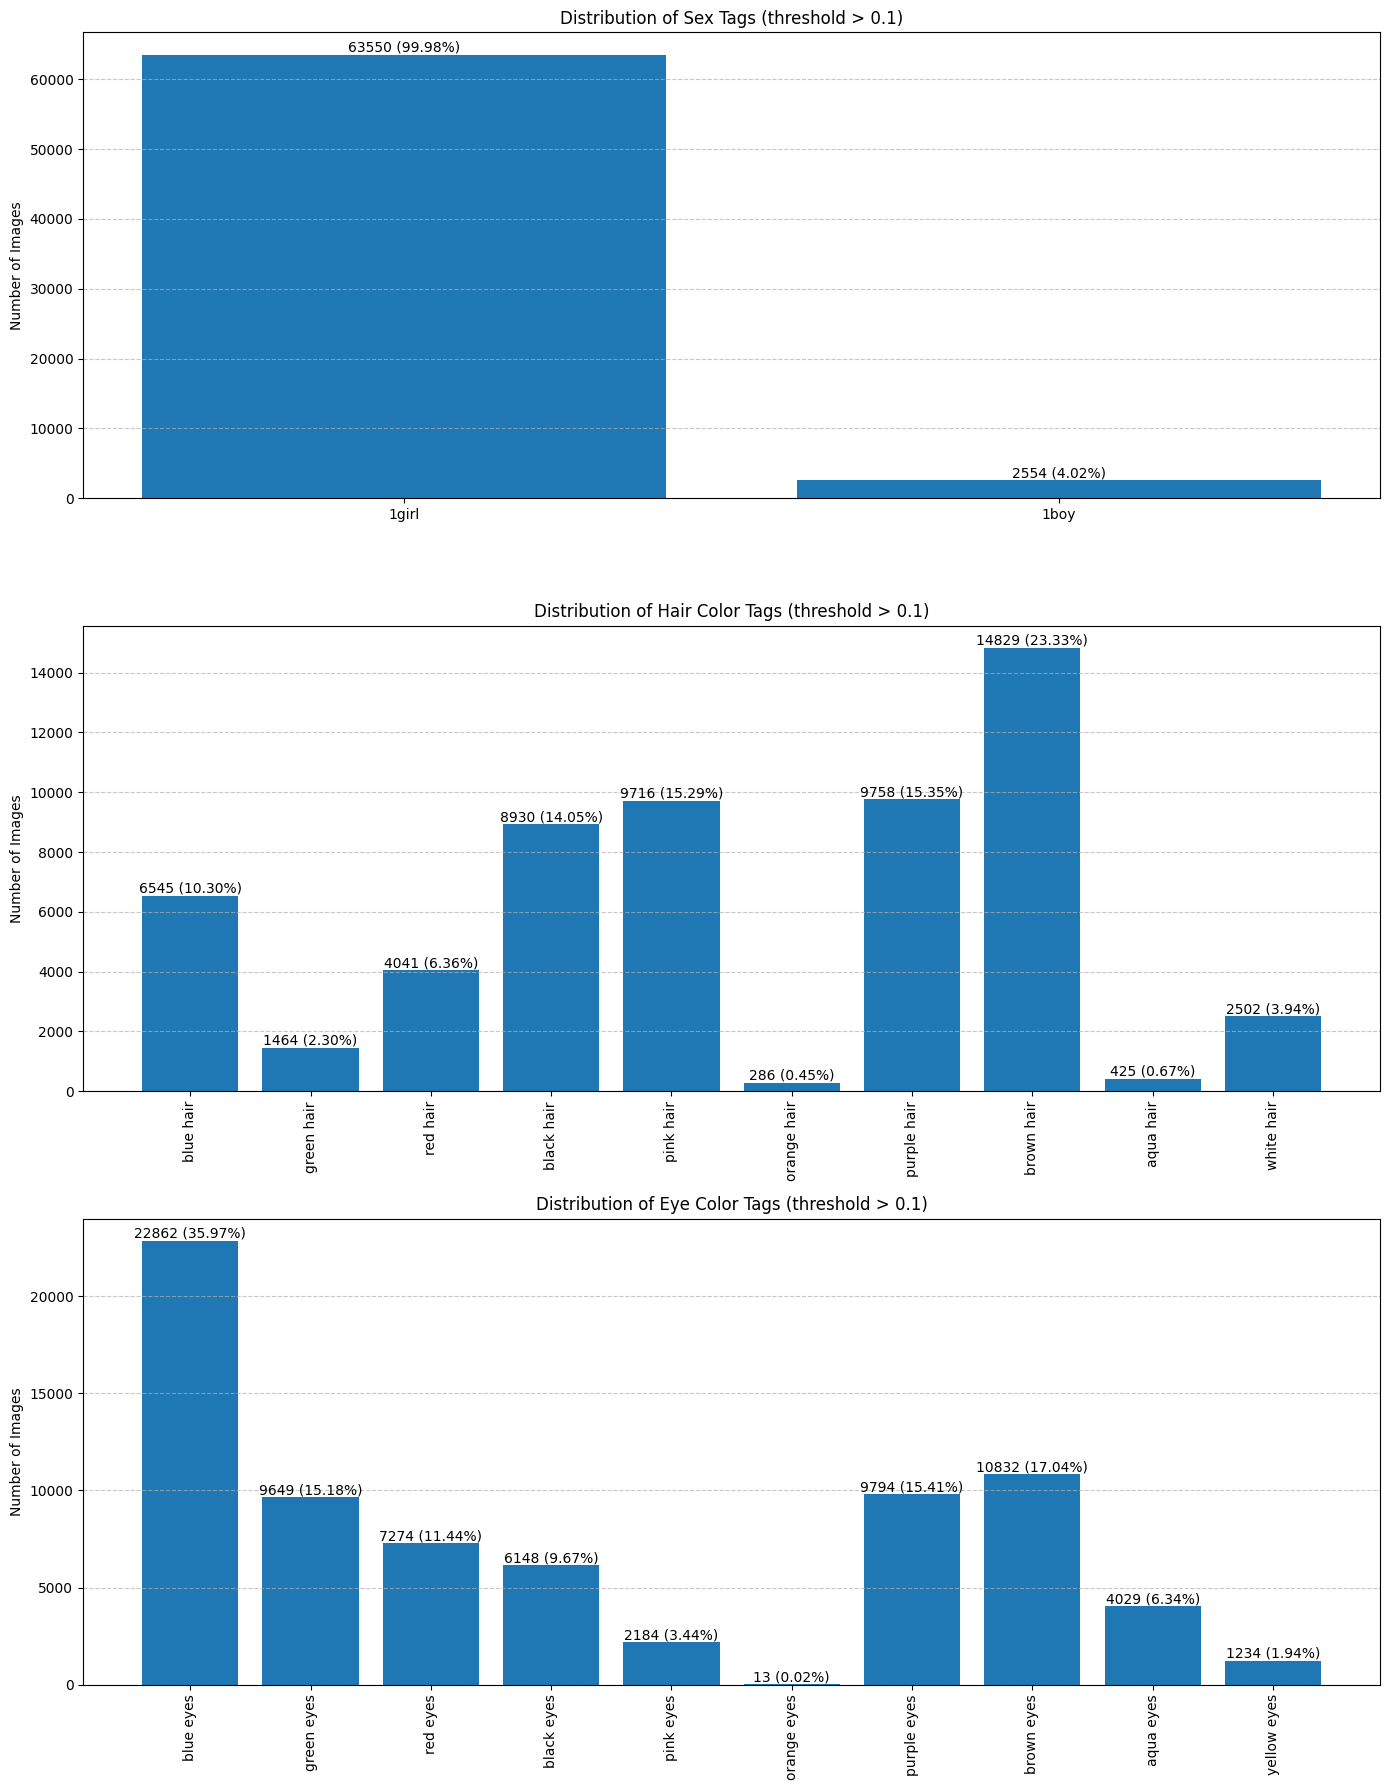

In [70]:
# Create separate plots for each category
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Plot Sex distribution
sex_data = tag_distribution[tag_distribution['Category'] == 'Sex']
bars1 = axes[0].bar(sex_data['Tag'], sex_data['Count'])
axes[0].set_title(f'Distribution of Sex Tags (threshold > {threshold})')
axes[0].set_ylabel('Number of Images')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height} ({sex_data["Percentage"].iloc[sex_data["Count"].tolist().index(height)]:.2f}%)',
                 ha='center', va='bottom')

# Plot Hair Color distribution
hair_data = tag_distribution[tag_distribution['Category'] == 'Hair Color']
bars2 = axes[1].bar(hair_data['Tag'], hair_data['Count'])
axes[1].set_title(f'Distribution of Hair Color Tags (threshold > {threshold})')
axes[1].set_ylabel('Number of Images')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].tick_params(axis='x', rotation=90)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height} ({hair_data["Percentage"].iloc[hair_data["Count"].tolist().index(height)]:.2f}%)',
                 ha='center', va='bottom')

# Plot Eye Color distribution
eye_data = tag_distribution[tag_distribution['Category'] == 'Eye Color']
bars3 = axes[2].bar(eye_data['Tag'], eye_data['Count'])
axes[2].set_title(f'Distribution of Eye Color Tags (threshold > {threshold})')
axes[2].set_ylabel('Number of Images')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].tick_params(axis='x', rotation=90)
for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                 f'{height} ({eye_data["Percentage"].iloc[eye_data["Count"].tolist().index(height)]:.2f}%)',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()